<a href="https://colab.research.google.com/github/krishnarevi/TSAI_END2.0_Session9/blob/main/Part1_Classification_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment analysis with LSTM

Machine learning model to detect sentiment of movie reviews from IMDb dataset using PyTorch and TorchText. 

## Preparing Data

One of the main concepts of TorchText is the `Field`. These define how your data should be processed. In our sentiment classification task the data consists of both the raw string of the review and the sentiment, either "pos" or "neg".
 

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)#setting random seed for reproducibility
torch.backends.cudnn.deterministic = True
#The parameters of a `Field` specify how the data should be processed. 
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')#`tokenize='spacy' defines that the "tokenization" should be done using the `spaCy` tokenizer. `tokenizer_language` tells torchtext which spaCy model to use. We use the `en_core_web_sm` model 

LABEL = data.LabelField(dtype = torch.float)#define how to process the sentiment


Loads IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review.

In [ ]:
from torchtext.legacy import datasets
'''downloads the IMDb dataset and splits it into the train/test splits as 'torchtext.datasets' objects.
 It process the data using the 'Fields' we have previously defined. '''

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)#load the IMDb dataset.

View how many examples are in each split.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['I', 'love', 'this', 'movie', '.', 'As', 'a', 'kid', ',', 'this', 'was', 'one', 'of', 'the', 'first', 'movies', 'I', 'saw', 'that', 'made', 'me', 'flinch', '.', 'Sure', ',', 'it', 'is', 'mild', 'now', ',', 'but', 'back', 'in', 'the', 'day', ',', 'it', 'was', 'awesome', '.', 'Dentists', 'are', 'one', 'thing', 'so', 'many', 'people', 'fear', ',', 'so', 'why', 'not', 'do', 'a', 'movie', 'about', 'a', 'killer', 'dentist', '?', 'It', "'s", 'cheesy', ',', 'it', "'s", 'fun', ',', 'sometimes', 'it', "'s", 'scary', ',', 'but', 'it', 'is', 'awesome', '.', 'And', 'I', 'have', 'always', 'had', 'a', 'love', 'for', 'medical', 'horror', '.', 'And', 'Corbin', 'Bernsen', 'plays', 'Dr.', 'Feinstone', 'perfectly', ',', 'no', 'one', 'could', 'have', 'done', 'it', 'better', '.', 'And', 'for', 'a', 'low', 'budget', 'horror', 'film', ',', 'the', 'effects', 'and', 'such', 'are', 'quite', 'good', '.', 'And', 'I', 'also', 'love', 'the', 'theme', 'music', ',', 'it', 'goes', 'well', 'with', 'the', 'film

The IMDb dataset only has train/test splits, so we need to create a validation set. We can do this with the `.split()` method.By default this splits 70/30.
We also pass our random seed to the `random_state` argument, ensuring that we get the same train/validation split each time.

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Again, we'll view how many examples are in each split.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


Next, we have to build a _vocabulary_. This is a effectively a look up table where every unique word in data set has a corresponding _index_ (an integer).We do this as our machine learning model cannot operate on strings, only numbers. Each _index_ is used to construct a _one-hot_ vector for each word.

The number of unique words in our training set is over 100,000, which means that our one-hot vectors will have over 100,000 dimensions! This will make training slow 
To cut down our vocabulary effectively we builds the vocabulary, only keeping the most common `max_size` tokens.

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE
                )

LABEL.build_vocab(train_data)


we only build the vocabulary on the training set since our machine learning system you do not want to look at the test set in any way

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2



View most common words in the vocabulary and their frequencies.

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 204654), (',', 193706), ('.', 166654), ('a', 110379), ('and', 110255), ('of', 101985), ('to', 94532), ('is', 77157), ('in', 61939), ('I', 54100), ('it', 53465), ('that', 49472), ('"', 44818), ("'s", 43285), ('this', 42954), ('-', 37418), ('/><br', 36182), ('was', 35177), ('as', 30666), ('with', 30171)]


We can also see the vocabulary directly using either the `stoi` (**s**tring **to** **i**nt) or `itos` (**i**nt **to**  **s**tring) method.

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


We can also check the labels, ensuring 0 is for negative and 1 is for positive.

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})



The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a `BucketIterator` which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We also want to place the tensors returned by the iterator on the GPU. PyTorch handles this using `torch.device`, we then pass this device to the iterator.

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

Save tokenizer for later use

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(TEXT.vocab.stoi, tokens)

## Build the Model

The next stage is building the model that we'll eventually train and evaluate. 

We'll be using a  RNN architecture called a Long Short-Term Memory (LSTM). LSTM better than a standard RNN. Standard RNNs suffer from the vanishing gradient problem. LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple _gates_ which control the flow of information into and out of the memory.



In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers): 
         
        super().__init__()

### LSTM Architecture
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)#embedding layer is used to transform our sparse one-hot vector into a dense embedding vector
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers) #LSTM with two layers ,takes in dense vector and the previous hidden state
            
        
        self.fc = nn.Linear(hidden_dim , output_dim)# linear layer takes the final hidden state and feeds it through a fully connected layer, transforming it to the correct output dimension
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        embedded = self.embedding(text)
        
        # The final hidden state, hidden, has a shape of [num layers * num directions, batch size, hid dim]
        output, (hidden, cell) = self.lstm(embedded) #output and a tuple of the final hidden state and the final cell state

        hidden =  hidden[-1,:,:]  #final hidden state of our LSTM 

        return self.fc(hidden.squeeze(0))

We now create an instance of our LSTM class. 


In [ ]:
INPUT_DIM = len(TEXT.vocab)#dimension of the one-hot vectors
EMBEDDING_DIM = 100 #size of the dense word vectors
HIDDEN_DIM = 256 #size of the hidden states
OUTPUT_DIM = 1 #number of classes
N_LAYERS = 2 # number of layers


model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS)


Let's also create a function that will tell us how many trainable parameters our model has so we can compare the number of parameters across different models.

In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,393,385 trainable parameters


## Train the Model
Now we'll set up the training and then train the model.

First, we'll create an optimizer. This is the algorithm we use to update the parameters of the module. Here, we'll use `Adam`. Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

Next, we'll define our loss function.
The loss function here is _binary cross entropy with logits_. 

Our model currently outputs an unbound real number. As our labels are either 0 or 1, we want to restrict the predictions to a number between 0 and 1. We do this using the _sigmoid_ or _logit_ functions. 

We then use this bound scalar to calculate the loss using binary cross entropy. 

The `BCEWithLogitsLoss` criterion carries out both the sigmoid and the binary cross entropy steps.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Using `.to`, we can place the model and the criterion on the GPU  

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Let's write function to calculate the accuracy. 

This function first feeds the predictions through a sigmoid layer, squashing the values between 0 and 1, we then round them to the nearest integer. This rounds any value greater than 0.5 to 1 (a positive sentiment) and the rest to 0 (a negative sentiment).

We then calculate how many rounded predictions equal the actual labels and average it across the batch.

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import ConfusionMatrix
from torchmetrics.functional import accuracy,precision,recall,f1

def evaluation_metrics(prediction, target) :
  """ Returns accuracy,precision ,recall,f1 score per batch """
  
  preds = torch.sigmoid(prediction)
  target=target.int()
  # print(preds)
  # print(target)

  acc_value = accuracy(preds, target,multiclass=False)
  precision_value = precision(preds, target,multiclass=False)
  recall_value = recall(preds, target,multiclass=False)
  f1_value = f1(preds, target,multiclass=False)
  return acc_value, precision_value, recall_value, f1_value

The `train` function iterates over all examples, one batch at a time. 


In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss,epoch_acc,epoch_psn,epoch_recall,epoch_f1_score = 0,0,0,0,0
    
    model.train()#put the model in "training mode"
    
    for batch in iterator:
        
        optimizer.zero_grad()#Zero accumulated gradients
                
        predictions = model(batch.text).squeeze(1)#feed the batch of sentences, batch.text, into the model
        
        loss = criterion(predictions, batch.label)#calculate loss
        
        # acc = binary_accuracy(predictions, batch.label)#calculate accuracy
        acc,psn,recal,f1_score= evaluation_metrics(predictions, batch.label)
        
        loss.backward()#calculate the gradient of each parameter 
        
        optimizer.step()#update the parameters using the gradients and optimizer algorithm 
        
        epoch_loss += loss.item()#loss is accumulated across the epoch
        epoch_acc += acc.item()# accuracy is accumulated across the epoch
        epoch_psn +=psn.item()
        epoch_recall +=recal.item()
        epoch_f1_score +=f1_score.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator),epoch_psn / len(iterator), epoch_recall / len(iterator), epoch_f1_score/ len(iterator)

`evaluate` function iterates over all examples, one batch at a time.

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss,epoch_acc,epoch_psn,epoch_recall,epoch_f1_score = 0,0,0,0,0
    # epoch_acc = 0
    
    model.eval()#puts the model in "evaluation mode"
    
    with torch.no_grad():#No gradients are calculated on PyTorch operations inside this block, causes less memory to be used and speeds up computation.
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)#feed the batch of sentences, batch.text, into the model
            
            loss = criterion(predictions, batch.label)#calculate loss
            
            # acc = binary_accuracy(predictions, batch.label)#calculate accuracy
            acc,psn,recal,f1_score= evaluation_metrics(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_psn +=psn.item()
            # epoch_acc_score +=acc_score.item()
            epoch_recall +=recal.item()
            epoch_f1_score +=f1_score.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),epoch_psn / len(iterator), epoch_recall / len(iterator), epoch_f1_score/ len(iterator)

We'll also create a function to tell us how long an epoch takes to compare training times between models.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.

At each epoch, if the validation loss is the best we have seen so far, we'll save the parameters of the model and then after training has finished we'll use that model on the test set.

We will also evaluate quality of predictions made by model using classification metrics like accuracy , precision, recall and f1 score

In [ ]:
N_EPOCHS=10
best_valid_loss = float('inf')
train_los, train_acc, train_psn, train_recal, train_f1=[],[],[],[],[]
valid_los, valid_acc, valid_psn, valid_recal, valid_f1=[],[],[],[],[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    # train the model
    train_loss, train_accuracy,train_precision,train_recall,train_f1_score = train(model, train_iterator, optimizer, criterion)
    train_los.append(train_loss)
    train_acc.append(train_accuracy)
    train_psn.append(train_precision)
    train_recal.append(train_recall)
    train_f1.append(train_f1_score)
    
    
    # evaluate the model
    valid_loss, valid_accuracy,valid_precision,valid_recall,valid_f1_score = evaluate(model, valid_iterator, criterion)
    valid_los.append(valid_loss)
    valid_acc.append(valid_accuracy)
    valid_psn.append(valid_precision)
    valid_recal.append(valid_recall)
    valid_f1.append(valid_f1_score)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}% | Train Precision: {train_precision*100:.2f}% | Train Recall: {train_recall*100:.2f}% | Train F1: {train_f1_score*100:.2f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_accuracy*100:.2f}% | Val.Precision: {valid_precision*100:.2f}%  | Val.Recall: {valid_recall*100:.2f}% | Val.F1: {valid_f1_score*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 0.692 | Train Acc: 51.53% | Train Precision: 33.89% | Train Recall: 40.98% | Train F1: 33.02
	 Val. Loss: 0.688 |  Val. Acc: 54.32% | Val.Precision: 52.88%  | Val.Recall: 91.93% | Val.F1: 66.58%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 0.608 | Train Acc: 66.22% | Train Precision: 66.39% | Train Recall: 65.15% | Train F1: 62.48
	 Val. Loss: 0.462 |  Val. Acc: 78.60% | Val.Precision: 78.53%  | Val.Recall: 79.12% | Val.F1: 78.40%
Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 0.370 | Train Acc: 84.27% | Train Precision: 85.20% | Train Recall: 83.35% | Train F1: 83.47
	 Val. Loss: 0.341 |  Val. Acc: 86.10% | Val.Precision: 86.12%  | Val.Recall: 86.22% | Val.F1: 85.84%
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 0.253 | Train Acc: 90.10% | Train Precision: 90.63% | Train Recall: 89.77% | Train F1: 89.69
	 Val. Loss: 0.315 |  Val. Acc: 87.34% | Val.Precision: 88.29%  | Val.Recall: 86.25% | Val.F1: 86.95%
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 

Now Let's visualize our model performance

Loss

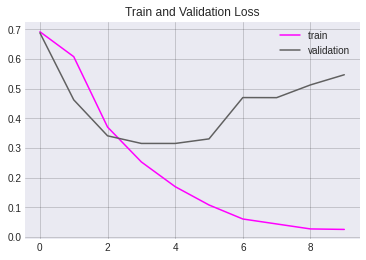

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_los, color = 'magenta')
plt.plot(valid_los, color = '#606060')
plt.title('Train and Validation Loss')
plt.legend(['train ', 'validation'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

Here we observe our traing loss is gradually decreasing which is good .But our validation loss starts to increase after decreasing for initial few epochs.This could be due to our mode is overfitting on training data , we could try adding regularization and reduction in model complexity to overcome this.

Accuracy

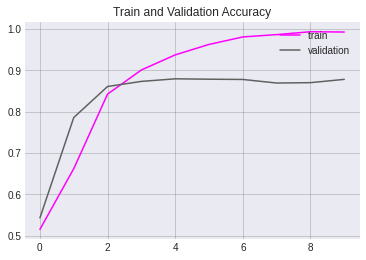

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_acc, color = 'magenta')
plt.plot(valid_acc, color = '#606060')
plt.title('Train and Validation Accuracy')
plt.legend(['train ', 'validation'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

Here we observe both our train accuracy is improving.But validation accuracy is not improving further after few initial epochs.The gap between training and validation accuracy is a clear indication of overfitting. The larger the gap, the higher the overfitting. Our training accuracy is around 99 % while bestvalidation accuracy is 87.97 %

Precision

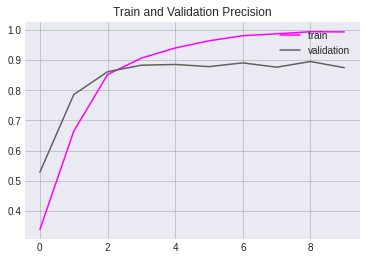

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_psn, color = 'magenta')
plt.plot(valid_psn, color = '#606060')
plt.title('Train and Validation Precision')
plt.legend(['train ', 'validation'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

Precision is the ratio between the True Positives and all the Positives. For our problem statement, that would be the measure of reviews that we correctly identify as positive out of all the positive reviews. 

What is the Precision for our model? Yes, it is 0.89 or, when it predicts that a review is positive, it is correct around 89% of the time.

Recall

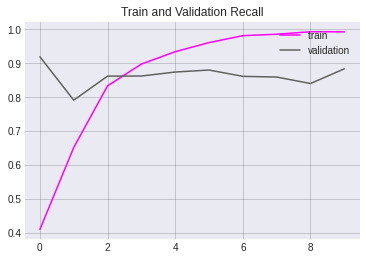

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_recal, color = 'magenta')
plt.plot(valid_recal, color = '#606060')
plt.title('Train and Validation Recall')
plt.legend(['train ', 'validation'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

The recall is the measure of our model correctly identifying True Positives. Thus, for all the reviews that are actually positive, recall tells us how many we correctly identified as positive. 
For our model, Recall  = 0.88,which is pretty good. Recall also gives a measure of how accurately our model is able to identify the relevant data. We refer to it as Sensitivity or True Positive Rate. 
 

F1 Score

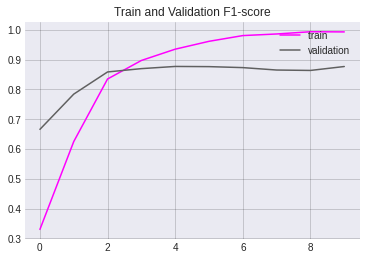

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(train_f1, color = 'magenta')
plt.plot(valid_f1, color = '#606060')
plt.title('Train and Validation F1-score')
plt.legend(['train ', 'validation'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is ~.88.,which is pretty good

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

Test accuracy

In [ ]:
model.load_state_dict(torch.load('saved_weights.pt'))

test_loss, test_acc,test_psn,test_recal,test_f1 = evaluate(model, test_iterator, criterion)

print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test Precision: {test_psn*100:.2f}%  | Test Recall: {test_recal*100:.2f}% | Test F1: {test_f1*100:.2f}%')

	 Test Loss: 0.323 |  Test Acc: 87.46% | Test Precision: 78.40%  | Test Recall: 77.26% | Test F1: 76.90%


# User Input
We can now use our model to predict the sentiment of any sentence we give it. As it has been trained on movie reviews, the sentences provided should also be movie reviews.

Our predict_sentiment function does a few things:

sets the model to evaluation mode

*   sets the model to evaluation mode
*   tokenizes the sentence, i.e. splits it from a raw string into a list of tokens indexes the tokens by converting them into their integer representation from our vocabulary
*   converts the indexes, which are a Python list into a PyTorch tensor
*   add a batch dimension by unsqueezeing
*   squashes the output prediction from a real number between 0 and 1 with the sigmoid function.We are expecting reviews with a negative sentiment to return a value close to 0 and positive reviews to return a value close to 1.So we round the value to get exact values
*   converts the tensor holding a single value into an integer with the item() method.Select corresponding sentiment value from dictionary


In [ ]:
# load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();#sets the model to evaluation mode
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_review(sentence):
    categories = { 0:"negative",1:"positive"}
     # tokenize the sentences 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1) 
    # Get the model prediction                  
    prediction = torch.round(torch.sigmoid(model(tensor)))
    print(prediction)
    return categories[prediction.item()]


In [ ]:
classify_review("very bad movie ..!!")

tensor([0.], device='cuda:0', grad_fn=<RoundBackward>)


'negative'

In [ ]:
classify_review("Fantastic film.Loved it ")

tensor([1.], device='cuda:0', grad_fn=<RoundBackward>)


'positive'

In [ ]:
classify_review("Will Watch it again and again ")

tensor([1.], device='cuda:0', grad_fn=<RoundBackward>)


'positive'